<a href="https://colab.research.google.com/github/arthlz/Machine-Learning/blob/main/Perceptron_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forma 1 de se fazer:

In [ ]:
!pip install torch scikit-learn

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Transformação para converter imagens em tensores e normalizar
transform = transforms.Compose([
    transforms.ToTensor(),  # converte para tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalização dos dados
])

# Baixando o dataset MNIST-treino
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Baixando o dataset MNIST-teste
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Definindo proporção de treino/validação (ex: 90% treino, 10% validação)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Dividindo os dados
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Loaders para treino, validação e teste
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.06MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.92MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.34MB/s]


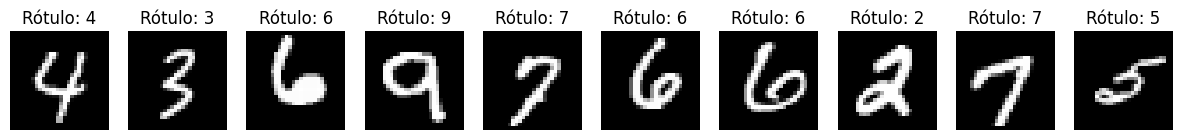

In [ ]:
# Exibindo algumas imagens do dataset de treino
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(example_data[i][0], cmap='gray')
    axes[i].set_title(f"Rótulo: {example_targets[i].item()}")
    axes[i].axis('off')
plt.show()

In [ ]:
# Definindo a estrutura do modelo que vamos utilizar
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer = nn.Linear(in_features=28*28, out_features=10)

    def forward(self, x):
        # 1. Achatar a imagem de entrada.
        x = x.view(x.size(0), -1)

        # 2. Passar os dados achatados pela nossa camada linear.
        # A camada produzirá os 'logits' (valores brutos de previsão).
        x = self.layer(x)

        return x

In [ ]:
model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (layer): Linear(in_features=784, out_features=10, bias=True)
)

In [ ]:
# Definindo a nossa função de perda e o otimizador

criterion = nn.CrossEntropyLoss()

# Defina a função de otimização, utilizando os parâmetros do modelo e uma taxa de aprendizado
# SGD (Gradiente Descendente Estocástico) com learning rate de 0.01.
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Defina o número de épocas de treinamento do modelo
epochs = 10 # 10 passagens pelo dataset de treino são um bom começo.


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)

    for epoch in range(epochs):
        # --- Treinamento ---
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            # 1. Zere os gradientes acumulados
            optimizer.zero_grad()

            # 2. Forward pass: gere as previsões
            outputs = model(data)

            # 3. calcule a perda entre previsão e rótulo
            # Compara as previsões (outputs) com os rótulos verdadeiros (targets).
            loss = criterion(outputs, targets)

            # 4. Backward pass: calcule os gradientes
            loss.backward()

            # 5. Atualize os pesos do modelo com os gradientes
            # O otimizador ajusta os pesos na direção que minimiza o erro.
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        avg_train_loss = train_loss / train_total
        train_acc = train_correct / train_total * 100

        # --- Validação ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        # Desativando o cálculo de gradientes
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        avg_val_loss = val_loss / val_total
        val_acc = val_correct / val_total * 100

        # --- Resultados ---
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Treino     - Loss: {avg_train_loss:.4f} | Acurácia: {train_acc:.2f}%")
        print(f"  Validação  - Loss: {avg_val_loss:.4f} | Acurácia: {val_acc:.2f}%\n")

In [ ]:
train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs)

Epoch 1/10
  Treino     - Loss: 0.4835 | Acurácia: 86.70%
  Validação  - Loss: 0.3413 | Acurácia: 90.27%

Epoch 2/10
  Treino     - Loss: 0.3388 | Acurácia: 90.38%
  Validação  - Loss: 0.3123 | Acurácia: 91.25%

Epoch 3/10
  Treino     - Loss: 0.3159 | Acurácia: 91.02%
  Validação  - Loss: 0.3007 | Acurácia: 91.48%

Epoch 4/10
  Treino     - Loss: 0.3041 | Acurácia: 91.37%
  Validação  - Loss: 0.2951 | Acurácia: 91.52%

Epoch 5/10
  Treino     - Loss: 0.2960 | Acurácia: 91.61%
  Validação  - Loss: 0.2923 | Acurácia: 91.83%

Epoch 6/10
  Treino     - Loss: 0.2908 | Acurácia: 91.73%
  Validação  - Loss: 0.2881 | Acurácia: 92.08%

Epoch 7/10
  Treino     - Loss: 0.2862 | Acurácia: 91.87%
  Validação  - Loss: 0.2847 | Acurácia: 92.23%

Epoch 8/10
  Treino     - Loss: 0.2825 | Acurácia: 92.03%
  Validação  - Loss: 0.2847 | Acurácia: 92.17%

Epoch 9/10
  Treino     - Loss: 0.2799 | Acurácia: 92.14%
  Validação  - Loss: 0.2817 | Acurácia: 92.22%

Epoch 10/10
  Treino     - Loss: 0.2774 | Acur

In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / total
    acc = correct / total * 100

    print(f"Teste Loss médio: {avg_loss:.4f} | Acurácia: {acc:.2f}%")

In [ ]:
test_model(model, test_loader, criterion, device)

Teste Loss médio: 0.2772 | Acurácia: 92.17%


In [ ]:
def visualize_predictions(model, data_loader, device, num_images=10):
    model.eval()
    model.to(device)
    images_shown = 0

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)

            fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
            for i in range(num_images):
                axes[i].imshow(data[i][0].cpu(), cmap='gray')
                axes[i].set_title(f"Predição: {predicted[i].item()}\nRótulo: {targets[i].item()}")
                axes[i].axis('off')
            plt.tight_layout()
            plt.show()

            images_shown += num_images
            break

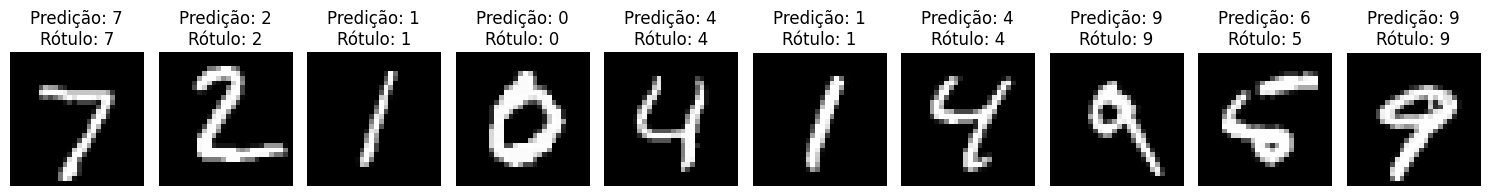

In [ ]:
visualize_predictions(model, test_loader, device)

# Forma 2 de se fazer

In [15]:
!pip install torch scikit-learn

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [17]:
# Transformação para converter imagens em tensores e normalizar
transform = transforms.Compose([
    transforms.ToTensor(),  # converte para tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalização dos dados
])

# Baixando o dataset MNIST-treino
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Baixando o dataset MNIST-teste
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Definindo proporção de treino/validação (ex: 90% treino, 10% validação)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Dividindo os dados
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Loaders para treino, validação e teste
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

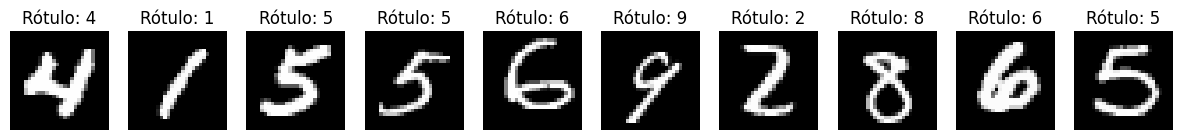

In [18]:
# Testando com algumas imagens do dataset de treino
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    axes[i].imshow(example_data[i][0], cmap='gray')
    axes[i].set_title(f"Rótulo: {example_targets[i].item()}")
    axes[i].axis('off')
plt.show()

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Defina aqui as layers, ativações e achatamento dos dados de entrada do modelo
        self.flatten = nn.Flatten()
        # Camada Linear 1: Entrada (784 features) -> 128 neurônios #28x28 é característica do formato MNIST
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU() #Não-linearidade, MUITO bom porque os pesos não ficam extremamente pequenos
        # Camada Linear 2: 128 neurônios -> 64 neurônios
        self.fc2 = nn.Linear(128, 64)
        # Camada Linear de Saída: 64 neurônios -> 10 neurônios
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Passo a passo do modelo
        x = self.flatten(x) # Achatamento dos dados de entrada
        x = self.fc1(x)     # Camada linear 1
        x = self.relu(x)    # Função de ativação não-linear
        x = self.fc2(x)     # Camada linear 2
        x = self.relu(x)
        x = self.fc3(x)     # Camada de saída

        return x

In [20]:
model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Isso daqui é bem legal: basicamente, se tiver gpu, vai ser utilizada a gpu, caso não tenha gpu disponível, vai ser usado a cpu para rodar
model.to(device)

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [21]:
# Loss function e otimizador
criterion = nn.CrossEntropyLoss() # Loss function

# Defina a função de otimização, utilizando os parâmetros do modelo e uma taxa de aprendizado
optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam > torch.sgd // Minha opinião // Adam é um otimizador adaptativo(a taxa de aprendizado é ajustada individualmente para cada parâmetro)
#                                                                                          enquanto o torch.sgd é um otimizador com taxa de aprendizado fixa para todos os parâmetros.

# Defina o número de épocas de treinamento do modelo
epochs = 10 # 10 passagens pelo dataset de treino

In [22]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)

    for epoch in range(epochs):
        # --- Treinamento ---
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            # 1. Zere os gradientes acumulados
            # PyTorch acumula gradientes, então precisamos zerá-los a cada novo batch.
            optimizer.zero_grad()

            # 2. Forward pass: gere as previsões
            # Passa os dados de entrada (imagens) pelo modelo.
            outputs = model(data)

            # 3. calcule a perda entre previsão e rótulo
            # Compara as previsões (outputs) com os rótulos verdadeiros (targets).
            loss = criterion(outputs, targets)

            # 4. Backward pass: calcule os gradientes
            # Calcula como cada peso do modelo contribuiu para o erro (loss).
            loss.backward()

            # 5. Atualize os pesos do modelo com os gradientes
            # O otimizador ajusta os pesos na direção que minimiza o erro.
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        avg_train_loss = train_loss / train_total
        train_acc = train_correct / train_total * 100

        # --- Validação ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        # Desativando o cálculo de gradientes
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * data.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        avg_val_loss = val_loss / val_total
        val_acc = val_correct / val_total * 100

        # --- Resultados ---
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Treino     - Loss: {avg_train_loss:.4f} | Acurácia: {train_acc:.2f}%")
        print(f"  Validação  - Loss: {avg_val_loss:.4f} | Acurácia: {val_acc:.2f}%\n")

In [23]:
train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs)

Epoch 1/10
  Treino     - Loss: 0.2833 | Acurácia: 91.73%
  Validação  - Loss: 0.1473 | Acurácia: 95.55%

Epoch 2/10
  Treino     - Loss: 0.1220 | Acurácia: 96.21%
  Validação  - Loss: 0.1109 | Acurácia: 96.53%

Epoch 3/10
  Treino     - Loss: 0.0838 | Acurácia: 97.41%
  Validação  - Loss: 0.1015 | Acurácia: 97.23%

Epoch 4/10
  Treino     - Loss: 0.0659 | Acurácia: 98.02%
  Validação  - Loss: 0.0953 | Acurácia: 97.17%

Epoch 5/10
  Treino     - Loss: 0.0504 | Acurácia: 98.43%
  Validação  - Loss: 0.0804 | Acurácia: 97.63%

Epoch 6/10
  Treino     - Loss: 0.0440 | Acurácia: 98.59%
  Validação  - Loss: 0.0800 | Acurácia: 97.73%

Epoch 7/10
  Treino     - Loss: 0.0356 | Acurácia: 98.84%
  Validação  - Loss: 0.0887 | Acurácia: 97.68%

Epoch 8/10
  Treino     - Loss: 0.0292 | Acurácia: 99.01%
  Validação  - Loss: 0.1014 | Acurácia: 97.45%

Epoch 9/10
  Treino     - Loss: 0.0291 | Acurácia: 98.96%
  Validação  - Loss: 0.1027 | Acurácia: 97.60%

Epoch 10/10
  Treino     - Loss: 0.0228 | Acur

In [23]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / total
    acc = correct / total * 100

    print(f"Teste Loss médio: {avg_loss:.4f} | Acurácia: {acc:.2f}%")

In [24]:
test_model(model, test_loader, criterion, device)

Teste Loss médio: 0.1000 | Acurácia: 97.61%


In [25]:
def visualize_predictions(model, data_loader, device, num_images=10):
    model.eval()
    model.to(device)
    images_shown = 0

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)

            fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
            for i in range(num_images):
                axes[i].imshow(data[i][0].cpu(), cmap='gray')
                axes[i].set_title(f"Predição: {predicted[i].item()}\nRótulo: {targets[i].item()}")
                axes[i].axis('off')
            plt.tight_layout()
            plt.show()

            images_shown += num_images
            break

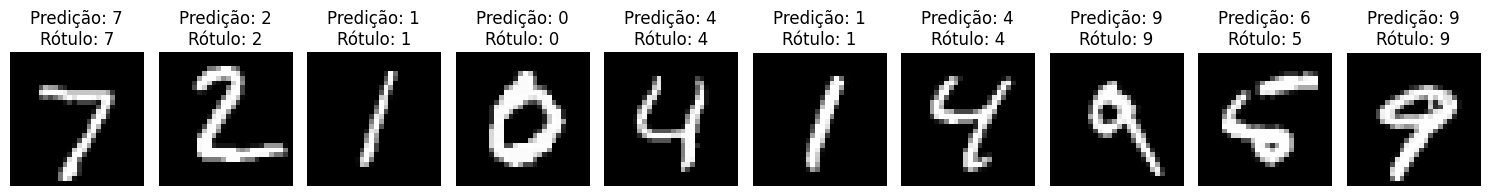

In [26]:
visualize_predictions(model, test_loader, device)

Eu fiz dois códigos porque eu só queria ver como que mudava a acurácia do modelo diante de algumas pequenas mudanças em relação a otimizador, maior quantidade de camadas, uso de funções não lineares(Relu) e é isso :)

Dá pra perceber que os resultados são melhores quando feito da 2 forma, porque há um avanço em relação a todos os fatores citados anteriormente, com uma diferença de acurácia de 92.1%, quando o código é realizado da primeira forma para 97.6% quando realizado da segunda forma.